**Calculating Magnitudes**
*Cedric Liang*

Now that we have our aperture photometry performed, we can calibrate a known star against our observed counts to find the apparent magnitudes of all the stars that we've identified in the cataloguing process. Once we have the magnitudes of the stars in each of our bands, we'll be able to use that data to perform scientific analyses.

We'll begin by importing the photometry data from our science images.

In [80]:
import numpy as np

from astropy import units as u
import astropy.table
import matplotlib.pyplot as plt
import os
import warnings
from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia
warnings.filterwarnings('ignore')
ROOT_PATH = os.path.normpath(os.getcwd() + os.sep + os.pardir)


In [81]:
from astropy.table import QTable

BANDS = ["B", "V", "R"]
BAND_INDICES = {
    "U": 0,
    "B": 1,
    "V": 2,
    "R": 3,
    "I": 4
}
GBAND_INDICES = {
    "G_BP": 0,
    "G": 1,
    "G_RP": 2
}

phot_tables = [QTable.read(
    f'{band}_band_aperture_sum.escv', format='ascii.ecsv') for band in BANDS]


We've imported our phot_tables for each band.

It is known that we are using filters similar to those used by Graham (1982). However, since our observations were not taken on a perfectly clear night, we will have to calibrate our observations against a canonical source of information for the magnitude of stellar objects. We will use GAIA, which requires us to translate between the G_BP, G and G_RP filters used in that mission and our UBVRI filters.


First, we'll define a helper class called Star.

In [82]:
# Here's the star class, which includes a name, coordinates, exposure time, airmass, UBVRI fluxes, UBVRI magnitudes.

class Star:
    def __init__(self):
        self.name = "Default name"                                # Object name
        self.filename = "NULL                                  "  # Image file name
        # J2000 coords ra+dec (initially given dummy values)
        self.ra = -99.0
        self.dec = -99.0
        # CCD pixel coords x-y (intially given dummy values)
        self.x = -99.0
        self.y = -99.0
        # UBVRI Fluxes (intially given dummy values)
        self.flux = [-99.0, -99.0, -99.0, -99.0, -99.0]
        # UBVRI Magnitudes (intially given dummy values)
        self.mag = [-99.0, -99.0, -99.0, -99.0, -99.0]
        # G_BP, G and G_RP Magnitudes (intially given dummy values)
        self.gaiamag = [-99.0, -99.0, -99.0]
        self.exptime = 1.0
        self.airmass = 1.0


Now, we can use a pre-prepared CSV file of GAIA data of the Graham (1982) stars. We'll read the data into our notebook with the following code, creating an array of ```Star``` objects.

In [83]:
grgaia = []
with open("graham_gaia.csv", "r") as f:
    grahamtext = f.readlines()
    for line in grahamtext:
        currentline = line.split(",")
        if currentline[0] != "Name":
            tstandard = Star()
            tstandard.name = currentline[0]
            tstandard.ra = float(currentline[1])
            tstandard.dec = float(currentline[2])
            tstandard.mag[0] = float(currentline[3])
            tstandard.mag[1] = float(currentline[4])
            tstandard.mag[2] = float(currentline[5])
            tstandard.mag[3] = float(currentline[6])
            tstandard.mag[4] = float(currentline[7])
            tstandard.gaiamag[0] = float(currentline[8])
            tstandard.gaiamag[1] = float(currentline[9])
            tstandard.gaiamag[2] = float(currentline[10])
            grgaia.extend([tstandard])


We'll produce for each band a polynomial fit corresponding to a relationship between Gaia filter colour and Graham filter colour. This will allow us to use the canonical value (from GAIA) for a single star in our open cluster.

All the literature analyses for Gaia data seems to use BR-RP instead of BP-G or G-RP, so I'll use BR-RP for all my bands as well.

[-0.05182288  0.30535539  1.31028698 -0.00259566]


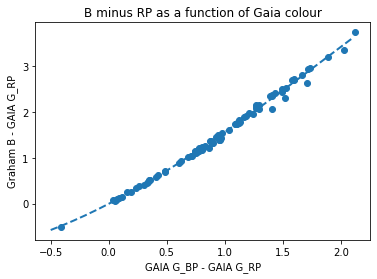

In [84]:
# B band

px = []
py = []

for obj in grgaia:
    if obj.mag[2] > 0.0 and obj.mag[2] < 20.0 \
        and obj.gaiamag[0] > 0.0 and obj.gaiamag[0] < 20.0 \
        and obj.gaiamag[1] > 0.0 and obj.gaiamag[1] < 20.0 \
            and (obj.mag[2]-obj.gaiamag[1])**2 < 2.25:
        px.append(obj.gaiamag[GBAND_INDICES["G_BP"]] -
                  obj.gaiamag[GBAND_INDICES["G_RP"]])      # G_BP minus G
        py.append(obj.mag[BAND_INDICES["B"]] -
                  obj.gaiamag[GBAND_INDICES["G_RP"]])          # B minus G

# Here, we're using np.polyfit to find a polynomial fit of the x and y data. The third argument is 2 to ensure that we fit a degree 2 polynomial (a quadratic).

Bpoly = np.polyfit(px, py, 3)
# Vpoly is a polynomial fit for the B-band
print(Bpoly)

plx = np.arange(-0.5, 2.2, 0.1).tolist()
ply = [Bpoly[3]+Bpoly[2]*x+Bpoly[1]*x*x+Bpoly[0]*(x**3) for x in plx]

plt.title('B minus RP as a function of Gaia colour')
plt.ylabel('Graham B - GAIA G_RP')
plt.xlabel('GAIA G_BP - GAIA G_RP')
plt.scatter(px, py, marker='o')
plt.plot(plx, ply, linestyle='dashed', linewidth=2)

# Here, we create a plot. The key lines is plt.scatter, which creates a scatter graph from the data, with each dot being a star's x and y value.
# The last line plots the polynomial fit line using the sample data of the points on the polynomial fit.


[0.01049595 0.05881496 0.68623525 0.01175054]


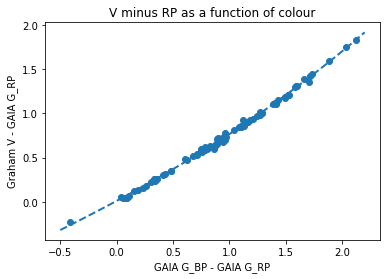

In [85]:
# V band

px = []
py = []

for obj in grgaia:
    if obj.mag[2] > 0.0 and obj.mag[2] < 20.0 \
        and obj.gaiamag[0] > 0.0 and obj.gaiamag[0] < 20.0 \
        and obj.gaiamag[1] > 0.0 and obj.gaiamag[1] < 20.0 \
            and (obj.mag[2]-obj.gaiamag[1])**2 < 2.25:
        px.append(obj.gaiamag[GBAND_INDICES["G_BP"]] -
                  obj.gaiamag[GBAND_INDICES["G_RP"]])      # G_BP minus G
        py.append(obj.mag[BAND_INDICES["V"]] -
                  obj.gaiamag[GBAND_INDICES["G_RP"]])          # V minus G

# Here, we're using np.polyfit to find a polynomial fit of the x and y data. The third argument is 2 to ensure that we fit a degree 2 polynomial (a quadratic).

Vpoly = np.polyfit(px, py, 3)
# Vpoly is a polynomial fit for the V-band
print(Vpoly)

plx = np.arange(-0.5, 2.3, 0.1).tolist()
ply = [Vpoly[3]+Vpoly[2]*x+Vpoly[1]*x*x+Vpoly[0]*(x**3) for x in plx]

plt.title('V minus RP as a function of colour')
plt.ylabel('Graham V - GAIA G_RP')
plt.xlabel('GAIA G_BP - GAIA G_RP')
plt.scatter(px, py, marker='o')
plt.plot(plx, ply, linestyle='dashed', linewidth=2)

# Here, we create a plot. The key lines is plt.scatter, which creates a scatter graph from the data, with each dot being a star's x and y value.
# The last line plots the polynomial fit line using the sample data of the points on the polynomial fit.


[ 0.02956061 -0.03279723  0.32480557  0.00978451]


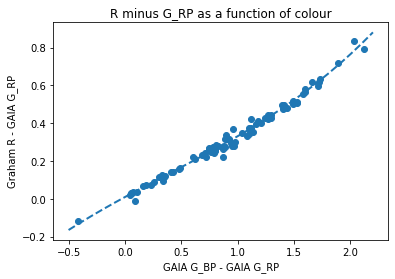

In [86]:
# R band

px = []
py = []

for obj in grgaia:
    if obj.mag[2] > 0.0 and obj.mag[2] < 20.0 \
        and obj.gaiamag[0] > 0.0 and obj.gaiamag[0] < 20.0 \
        and obj.gaiamag[1] > 0.0 and obj.gaiamag[1] < 20.0 \
            and (obj.mag[2]-obj.gaiamag[1])**2 < 2.25:
        px.append(obj.gaiamag[GBAND_INDICES["G_BP"]] -
                  obj.gaiamag[GBAND_INDICES["G_RP"]])
        py.append(obj.mag[BAND_INDICES["R"]] -
                  obj.gaiamag[GBAND_INDICES["G_RP"]])   


Rpoly = np.polyfit(px, py, 3)
# Rpoly is a polynomial fit for the R-band
print(Rpoly)

plx = np.arange(-0.5, 2.3, 0.1).tolist()
ply = [Rpoly[3]+Rpoly[2]*x+Rpoly[1]*x*x+Rpoly[0]*(x**3) for x in plx]

plt.title('R minus G_RP as a function of colour')
plt.ylabel('Graham R - GAIA G_RP')
plt.xlabel('GAIA G_BP - GAIA G_RP')
plt.scatter(px, py, marker='o')
plt.plot(plx, ply, linestyle='dashed', linewidth=2)

# Here, we create a plot. The key lines is plt.scatter, which creates a scatter graph from the data, with each dot being a star's x and y value.
# The last line plots the polynomial fit line using the sample data of the points on the polynomial fit.


We will now need to select a reference star. Given that we have two exposure times, it is pertinent to select two different reference stars - one for each exposure time.

For the saturated stars with 5 second exposure times, I select the star with id 430, with centre located at x = 729, y = 633. Using Aladin, this is a star named CPD-57 3523 at 
>RA 158.99042161857, Dec -58.22243342766.

For the 60 second exposure times, I select the star at (700, 90), since it's relatively bright in all bands, isn't saturated, and does not have an aperture that overlaps with another star's aperture. Finding this star on Aladin was NOT trivial, but after some careful geometric reasoning, I've identified it as Cl* NGC 3293 ESL 80 with 
>RA 159.0273483404, dec -58.1152785577.

We can now query Gaia for the chosen stars. We'll use the more recent Gaia EDR3 data here.

In [87]:
Gaia.MAIN_GAIA_TABLE = "gaiaedr3.gaia_source"

coord_fivesec_ref = SkyCoord(ra=158.99042161857, dec=-58.22243342766,
                 unit=(u.degree, u.degree), frame='icrs')
coord_sixtysec_ref = SkyCoord(ra=159.0273483404, dec=-58.1152785577,
                 unit=(u.degree, u.degree), frame='icrs')

gmag_fivesec_ref = [-99.0, -99.0, -99.0]
gmag_sixtysec_ref = [-99.0, -99.0, -99.0]

# initialise g magnitudes to values unreasonably bright - as a placeholder
radius = u.Quantity(0.001, u.deg)
# make the api call
r_fivesec = Gaia.cone_search_async(coord_fivesec_ref, radius).get_results()
r_sixtysec = Gaia.cone_search_async(coord_sixtysec_ref, radius).get_results()

if len(r_fivesec) > 0:
    gmag_fivesec_ref[0] = r_fivesec[0]['phot_bp_mean_mag']
    gmag_fivesec_ref[1] = r_fivesec[0]['phot_g_mean_mag']
    gmag_fivesec_ref[2] = r_fivesec[0]['phot_rp_mean_mag']
    print(gmag_fivesec_ref)

if len(r_sixtysec) > 0:
    gmag_sixtysec_ref[0] = r_sixtysec[0]['phot_bp_mean_mag']
    gmag_sixtysec_ref[1] = r_sixtysec[0]['phot_g_mean_mag']
    gmag_sixtysec_ref[2] = r_sixtysec[0]['phot_rp_mean_mag']
    print(gmag_sixtysec_ref)


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
[7.976616, 7.9854736, 7.929925]
[12.453176, 12.390415, 12.255338]


We have the Gaia magnitudes for each of our reference stars. We can now use the polynomials to compute a magnitude for each band. Since we're applying a different procedure for the B band and the V and R bands, we'll have to use a different procedure/polyfit.

In [88]:
band_func = lambda band_poly: lambda x: band_poly[0]*x**3 + band_poly[1]*x**2 + band_poly[2]*x + band_poly[3]


bp_minus_rp_five = gmag_fivesec_ref[GBAND_INDICES["G_BP"]] - gmag_fivesec_ref[GBAND_INDICES["G_RP"]]
bp_minus_rp_sixty = gmag_sixtysec_ref[GBAND_INDICES["G_BP"]] - gmag_sixtysec_ref[GBAND_INDICES["G_RP"]]


b_mag_five_ref = band_func(Bpoly)(bp_minus_rp_five) + gmag_fivesec_ref[GBAND_INDICES["G_RP"]]
b_mag_sixty_ref = band_func(Bpoly)(bp_minus_rp_sixty) + gmag_sixtysec_ref[GBAND_INDICES["G_RP"]]

v_mag_five_ref = band_func(Vpoly)(bp_minus_rp_five) + gmag_fivesec_ref[GBAND_INDICES["G_RP"]]
v_mag_sixty_ref = band_func(Vpoly)(bp_minus_rp_sixty) + gmag_sixtysec_ref[GBAND_INDICES["G_RP"]]

r_mag_five_ref = band_func(Rpoly)(bp_minus_rp_five) + gmag_fivesec_ref[GBAND_INDICES["G_RP"]]
r_mag_sixty_ref = band_func(Rpoly)(bp_minus_rp_sixty) + gmag_sixtysec_ref[GBAND_INDICES["G_RP"]]


mags_5_ref = [b_mag_five_ref, v_mag_five_ref, r_mag_five_ref]
mags_60_ref = [b_mag_sixty_ref, v_mag_sixty_ref, r_mag_sixty_ref]


for idx, band in enumerate(BANDS):
    print(f"{band} mag five", mags_5_ref[idx])

print("")

for idx, band in enumerate(BANDS):
    print(f"{band} mag sixty", mags_60_ref[idx])


B mag five 7.989168254828981
V mag five 7.973845759530127
R mag five 7.954806461551107

B mag sixty 12.523516661107376
V mag sixty 12.405234825010451
R mag sixty 12.328326274016998


These magnitudes are roughly within agreement with SIMBAD values - the difference to database values for the first star is around 0.05 for each of the bands. For the second star, the difference is even less - the SIMBAD value for the B band magnitude is 12.50 compared to 12.52.

The B-V values are preserved across this transformation as well - the B-V value for the first star matches to the precision limit, and is miniscule for the second star. This indicates that our transformation seems to be valid, and allows us to use these stars as references without issues.

Let's first get the ID of our 60 second reference star.

In [89]:
phot_tables[0][abs(phot_tables[0]['xcenter'] - 700*u.pix) < 5.0 * u.pix]


id,xcenter,ycenter,aperture_sum,aperture_sum_err,exptime
,pix,pix,adu,adu,
int64,float64,float64,float64,float64,float64
40,696.8247992021144,91.10280339913609,67878.93767690932,460.01720262837557,60.0
187,698.6021737019083,310.1790414292676,24936.217940730912,283.17425354670445,60.0
299,697.6883170754917,477.5292681728969,12183.553895789773,257.31587604525754,60.0
338,703.5431794174943,535.2208831078118,27674.517407413292,273.1948322042358,60.0
412,697.796958614604,615.9904500397242,23273.082515397957,261.5647772190587,60.0
442,701.428863506606,642.7456704410946,27705.132775243474,263.1747812512213,60.0
491,701.0732030474193,689.5399084873304,25585.6280301527,270.43911486967465,60.0
784,697.9645215157283,1147.7289649718455,820.8520516870819,279.14431179407444,60.0


ID == 40.

In [90]:
reference_ids = [40, 430]

# getting the rows for the reference star ids
ref_phot_rows = [astropy.table.vstack(list(filter(
    lambda row: row['id'] in reference_ids, phot_tables[i]))) for i in range(len(BANDS))]

for idx, band in enumerate(BANDS):
    print(f"{band} band:")
    print(ref_phot_rows[idx])


B band:
 id      xcenter           ycenter      ...  aperture_sum_err  exptime
           pix               pix        ...        adu                
--- ----------------- ----------------- ... ------------------ -------
 40 696.8247992021144 91.10280339913609 ... 460.01720262837557    60.0
430 729.9605448166753 633.1271676312729 ... 1658.6720061876515     5.0
V band:
 id      xcenter           ycenter      ...  aperture_sum_err  exptime
           pix               pix        ...        adu                
--- ----------------- ----------------- ... ------------------ -------
 40 696.8247992021144 91.10280339913609 ... 1193.2284278215434    60.0
430 729.9605448166753 633.1271676312729 ...  5053.411891201255     5.0
R band:
 id      xcenter           ycenter      ...  aperture_sum_err  exptime
           pix               pix        ...        adu                
--- ----------------- ----------------- ... ------------------ -------
 40 696.8247992021144 91.10280339913609 ... 2162.9927

In [91]:
counts_5_ref = []
counts_60_ref = []

for idx, band in enumerate(BANDS):
    row5 = ref_phot_rows[idx][1]
    row60 = ref_phot_rows[idx][0]
    counts_5_ref.append([row5['aperture_sum'], row5['aperture_sum_err']])
    counts_60_ref.append([row60['aperture_sum'], row60['aperture_sum_err']])

# Example:
# B band 5 sec ref mag is given by mags_5_ref[0]
# B band 5 sec ref counts is given by counts_5_ref[0][0]
print(mags_5_ref[0])
print(counts_5_ref[0][0])

print(mags_60_ref[0])
print(counts_60_ref[0][0])


7.989168254828981
344301.6314052461
12.523516661107376
67878.93767690932


We've now extracted the aperture sums for each of our reference stars! This will let us equate the reference magnitudes we computed earlier to that number of counts, and use that to compute the magnitudes of every other star.

In [92]:
mag_table = astropy.table.Table()
mag_table.add_column(astropy.table.Column(name='id', dtype=np.int64))
mag_table.add_column(astropy.table.Column(name='xcenter', dtype=np.float64))
mag_table.add_column(astropy.table.Column(name='ycenter', dtype=np.float64))
mag_table.add_column(astropy.table.Column(name='Bmag', dtype=np.float64))
mag_table.add_column(astropy.table.Column(name='Vmag', dtype=np.float64))
mag_table.add_column(astropy.table.Column(name='Rmag', dtype=np.float64))


for row in phot_tables[0]:
    mag_table.add_row([row['id'], row['xcenter'],
                      row['ycenter'], -99.0, -99.0, -99.0])


invalid_rows = set()


for idx, band in enumerate(BANDS):
    # define convenience variables
    band_phot_table = phot_tables[idx]
    mag_col_name = f"{band}mag"
    ref_5_mag = mags_5_ref[idx]
    ref_60_mag = mags_60_ref[idx]
    ref_5_counts = counts_5_ref[idx][0]
    ref_60_counts = counts_60_ref[idx][0]

    for rowidx, row in enumerate(band_phot_table):
        star_id = row['id']
        star_counts = row['aperture_sum']

        ref_counts = ref_5_counts if row['exptime'] == 5.0 else ref_60_counts
        ref_mag = ref_5_mag if row['exptime'] == 5.0 else ref_60_mag

        star_mag = -2.5*np.log10(star_counts/(ref_counts * u.adu)) + ref_mag

        # if log is undefined, there are probably negative counts. Make sure to discard these rows.
        if np.isinf(star_mag) or np.isnan(star_mag):
            invalid_rows.add(rowidx)

        mag_table[rowidx][mag_col_name] = star_mag


mag_table.remove_rows(list(invalid_rows))

mag_table



id,xcenter,ycenter,Bmag,Vmag,Rmag
int64,float64,float64,float64,float64,float64
1,558.5821422495022,1.553447827399145,15.68928535739459,15.275841761053973,15.244903270383979
2,215.4588279399274,3.983022591080132,15.815771119099008,15.906980234932634,15.342412892913183
4,1373.7256085823674,13.534586033156419,14.203652326627292,14.078608650094244,14.026161934201072
5,733.2994363144586,13.335078874553421,15.885125083628285,14.929816212545855,14.504504540481872
6,1181.245040725141,13.348170003563451,15.885390773321472,15.02501002741372,15.007060184080622
7,336.13127255653905,17.162987601026444,15.609194810018852,15.290687290701829,14.847589411718948
8,788.9605066759916,16.500805548609634,13.018608379573829,12.747147500124049,12.532762523790582
9,144.72496142271015,18.682891776588065,15.145567356395862,15.57209316267854,15.013918170998622
11,1366.7676792434581,22.887029930438892,13.32410322845106,13.24406093481389,13.168136453554364


This looks good! We have our magnitudes in each band for the stars for which the measurements were valid. Let's save the data.

In [93]:
mag_table.write("obj_magnitudes.ecsv", overwrite=True)

I can now plot a histogram:

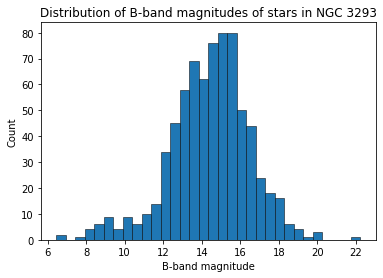

In [94]:
fig = plt.hist(np.array(mag_table[:]['Bmag']), bins=round((max(mag_table[:]['Bmag'])-min(mag_table[:]['Bmag']))/0.5), edgecolor='black', linewidth=0.5)
plt.xlabel("B-band magnitude")
plt.ylabel("Count")
plt.title("Distribution of B-band magnitudes of stars in NGC 3293")
plt.show()

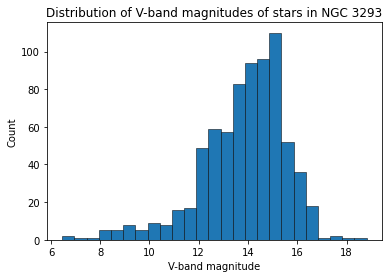

In [95]:
fig = plt.hist(np.array(mag_table[:]['Vmag']), bins=round((max(mag_table[:]['Vmag'])-min(mag_table[:]['Vmag']))/0.5), edgecolor='black', linewidth=0.5)
plt.xlabel("V-band magnitude")
plt.ylabel("Count")
plt.title("Distribution of V-band magnitudes of stars in NGC 3293")
plt.show()

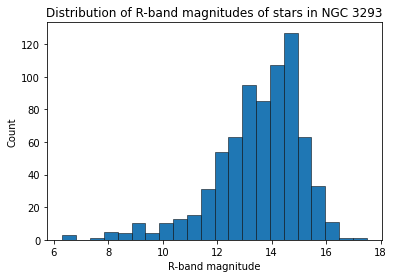

In [96]:
fig = plt.hist(np.array(mag_table[:]['Rmag']), bins=round((max(mag_table[:]['Rmag'])-min(mag_table[:]['Rmag']))/0.5), edgecolor='black', linewidth=0.5)
plt.xlabel("R-band magnitude")
plt.ylabel("Count")
plt.title("Distribution of R-band magnitudes of stars in NGC 3293")
plt.show()